# CS4487 Project: Image classification

## Code Reproduction
* ### Environment Requirments
  * #### Python Version >= 3.7
  * #### Pytorch Version =1.3
  * #### Nvdia GPU (for speed up training and testing)
  * #### 15GB RAM (If not enough RAM, please reduce batch_size)
* ### Run Codes
  * #### Run all the code from top to bottom
  * #### The first code cell helps install a progress bar library
  * #### Not necessary to load a saved model (This [code cell](#Load-saved-model) is not necessary to run)

## Regarding course project
* External training data is not allowed. Learning can only be performed on the 50,000 training images in **CIFAR10**
* The [**CIFAR10** dataset](https://www.cs.toronto.edu/~kriz/cifar.html) was comprised of 60,000 32 × 32 color photographs of objects from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
* Submit the results at [Kaggle CS4487 Course Project](https://www.kaggle.com/c/cs4487cp/)
* The second test set containing roughly 2,000 images (refer to test_data/y_test.npy)

## Evaluation Criteria 

* ### Classification Accuaracy:
  ### $$ Acc(f, D) = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}[y^i = f(x^i)]$$

* ### File Format:
Upload a file in CSV format, such as:

|         **Index**         |         **Category**        |
|---------------------------|-----------------------------|
| 0                         | 8                           |
| 1                         | 4                           |
| 2                         | 6                           |
| 3                         | 1                           |
| ......                    | ......                      |
| 11999                     | 2                           |

PyTorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

---
## Table of content (for quick jump)
* ### [Import Library](#Import-Library)
* ### [Data Preparation](#Data-Preparation)
* ### [Common Functions](#Common-Functions)
  * #### [Training Function](#Training-function)
  * #### [Testing Function](#Testing-function)
  * #### [Test for each category](#Test-for-each-category)
  * #### [Save Model](#Save-Model)
  * #### [Print Time](#Print-Time)
  * #### [Progress Bar](#Progress-Bar)
* ### [DenseNet (DN)](#DenseNet)
  * #### [Training](#Train-DenaseNet)
  * #### [Testing](#Test-DenseNet)
* ### [Run the model](#Run-the-model-in-project-test-data)
---
---

## Import Library

In [ ]:
%pip install progressbar2

In [1]:
import numpy as np
from numpy import *
import cv2
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import time
from _datetime import datetime
import pytz

import torch
import torchvision
from torch.utils import data
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torch.optim as optim

from progressbar import *
from sys import platform

import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

gd_root = "."  # For loacal run

basic_path = "basic_cifar_net.pth"
PATH_DPN = "DPN_cifar.pth"
PATH_Dense = "DenseNet.pth"

cuda


---
---
## Data Preparation

### Read CIFAR10 data
* The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.
* Loaded in this way, each of the batch files contains a dictionary with the following elements:
  * **data**: 
    * a 10,000 x 3,072 numpy array of uint8s. Each row of the array stores a 32 x 32 colour image. 
    * The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
    * The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
  * **labels**: 
    * a list of 10,000 numbers in the range 0 - 9. 
    * The number at index i indicates the label of the ith image in the array data.
* The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
  * **label_names** -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 
  * For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Loading and normalizing CIFAR10 to dataloader

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=256, 
                                           shuffle=True, 
                                           num_workers=8, 
                                           pin_memory=True
                                          )

testset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=32,
                                          shuffle=False, 
                                          num_workers=8,
                                          pin_memory=True
                                         )

In [5]:
train_size = len(trainset)
train_size
test_size = len(testset)
test_size
train_batch_len = len(train_loader)
train_batch_len
test_batch_len = len(test_loader)
test_batch_len

50000

10000

196

313

In [6]:
category_dict = {
    'airplane': 0, 
    'automobile': 1, 
    'bird': 2, 
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6, 
    'horse': 7, 
    'ship': 8, 
    'truck': 9
}

---
---
## Common Functions

### Mixup 
From [Facebook AI Research](https://github.com/facebookresearch/mixup-cifar10/blob/master/README.md)

In [7]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Training function

In [8]:
train_correct_rate = []
train_loss = []
learning_rate = []

In [9]:
def training(epoch_num: int, model_name: str, net):    
    
    final_loss = 0.0
    
    total = train_size
    
    net.train()
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        
        correct = 0
        run_loss  = 0.0
        
        train_bar = progress_bar(train_batch_len)
        
        print_time_and_msg(f"Training for epoch {epoch + 1}")
        
        for batch_idx, (inputs, targets) in enumerate(train_loader, 0):
                        
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Mixup
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 1.0)
            
            outputs = net(inputs)
            
            # forward + backward + optimize
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
#             loss = criterion(outputs, targets)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            run_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            
            final_loss = round(run_loss / train_batch_len, 3)
            
            train_bar.update(batch_idx)
        
        correct_rate = correct / total
        
        if epoch > 0:
            if correct_rate > max(train_correct_rate) or final_loss < min(train_loss):
                save_model(model_name, net)
            else:
                pass
        if epoch + 1 == epoch_num:
            save_model(model_name, net)
        
        print_time_and_msg(f"Trained Epoch {epoch + 1}. loss: {final_loss}. Correct/Total: {correct}/{total}, Correct rate: {correct_rate}")
        
        train_loss.append(final_loss)
        train_correct_rate.append(correct_rate)
        
        scheduler.step()
        learning_rate.append(scheduler.get_lr())
        
        print()
    
    print_time_and_msg(f'Finished training total {train_size} data for {epoch_num} epoches,\nthe final loss is {final_loss}')


### Testing function

In [10]:
def testing(net):
    test_bar = progress_bar(test_batch_len)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for ti, (inputs, targets) in enumerate(test_loader):
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            test_bar.update(ti)
    print()
    print(f'Accuracy of the network on the {test_size} test images: {100 * correct / total}%')



### Test for each category

In [11]:
def test_for_each(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    test_bar = progress_bar(test_batch_len)
    
    with torch.no_grad():
        for tei, (inputs, targets) in enumerate(test_loader):
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == targets).squeeze()
            for i in range(4):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
            test_bar.update(tei)
    
    print()
    for i in range(10):
        print(f'Accuracy of {list(category_dict)[i]} : {round(100 * class_correct[i] / class_total[i], 2)}%')

### Save Model

In [12]:
def save_model(model_name: str, net):
    PATH_basic = f'{gd_root}/models/{model_name}'
    torch.save(net.state_dict(), PATH_basic)
    print_time_and_msg(f"Saved model")

In [41]:
# save_model(PATH_Dense, densenet_net)

[23:29:07] - Saved model


### Print Time

In [13]:
def print_time_and_msg(msg: str) -> str:
    now_time = time.time()
    readable_time = datetime.fromtimestamp(now_time, pytz.timezone('Asia/Shanghai')).strftime(f'[%H:%M:%S] - {msg}')
    print(readable_time)

### Progress Bar

In [14]:
def progress_bar(max_val: int):
    bar = ProgressBar(
        widgets=[
            'Progress: ',
            Percentage(), ' ', 
            Bar('#'), ' ', 
            Timer(), ' ', 
            ETA(), ' '
        ], 
        max_value=max_val
    )
    return bar


### Plot

In [15]:
def plot_train_info():
    plt.figure(figsize=(20,10))
    x = [i for i in range(len(train_correct_rate))]
    y1 = train_correct_rate
    y2 = train_loss
    
    plt.plot(x, y1, label="train correct rate")
    plt.plot(x, y2, label="train loss")
    
    plt.legend(loc=0, numpoints=1)
    
    plt.xlabel("Epoch")

def plot_lerning_rate():
    plt.figure(figsize=(20,10))
    x = [i for i in range(len(learning_rate))]
    y = learning_rate
    plt.plot(x, y)
    plt.xlabel("Epoch")

# plot_train_info()

### Unpickle CIFAR data

In [16]:
def unpickle_cifar10(file: str) -> dict:
    full_name = f"{gd_root}/data/cifar-10-batches-py/{file}"
    
    with open(full_name, 'rb') as fi:
        cifar10_dict = pickle.load(fi, encoding='bytes')
    return cifar10_dict

cifar_meta = unpickle_cifar10("batches.meta")
cifar_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

---
---
## DenseNet
Code referenced from [kuangliu, GitHub](https://github.com/kuangliu/pytorch-cifar/blob/master/models/densenet.py)

In [17]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

### Train DenaseNet

#### Go to [training function](#Training-function)

In [18]:
densenet_net = DenseNet121()
densenet_net.to(device)
if device == 'cuda':
    densenet_net = torch.nn.DataParallel(densenet_net)
    cudnn.benchmark = True

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet_net.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-9)

### Load saved model

In [20]:
model_PATH = f"{gd_root}/models/{PATH_Dense}"
densenet_net.load_state_dict(torch.load(model_PATH))
print_time_and_msg(f"Loaded model: {PATH_Dense}")

<All keys matched successfully>

[23:29:54] - Loaded model: DenseNet.pth


In [22]:
epoches = 25

In [23]:
print_time_and_msg(f"Start training Dense Net for {epoches} epoches\n")
training(epoch_num=epoches, model_name=PATH_Dense, net=densenet_net)

[23:30:03] - Start training Dense Net for 25 epoches

[23:30:03] - Training for epoch 1


Progress:  99% |####################### | Elapsed Time: 0:00:47 ETA:   0:00:00 

[23:30:55] - Trained Epoch 1. loss: 0.853. Correct/Total: 27649/50000, Correct rate: 0.55298

[23:30:55] - Training for epoch 2


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:31:42] - Saved model
[23:31:42] - Trained Epoch 2. loss: 0.803. Correct/Total: 26204/50000, Correct rate: 0.52408

[23:31:42] - Training for epoch 3


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:32:29] - Trained Epoch 3. loss: 0.828. Correct/Total: 25109/50000, Correct rate: 0.50218

[23:32:29] - Training for epoch 4


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:33:15] - Trained Epoch 4. loss: 0.821. Correct/Total: 26546/50000, Correct rate: 0.53092

[23:33:15] - Training for epoch 5


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:34:01] - Trained Epoch 5. loss: 0.816. Correct/Total: 25287/50000, Correct rate: 0.50574

[23:34:01] - Training for epoch 6


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:34:48] - Trained Epoch 6. loss: 0.827. Correct/Total: 26480/50000, Correct rate: 0.5296

[23:34:48] - Training for epoch 7


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:35:34] - Saved model
[23:35:34] - Trained Epoch 7. loss: 0.764. Correct/Total: 28173/50000, Correct rate: 0.56346

[23:35:34] - Training for epoch 8


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:36:21] - Saved model
[23:36:21] - Trained Epoch 8. loss: 0.851. Correct/Total: 28724/50000, Correct rate: 0.57448

[23:36:21] - Training for epoch 9


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:37:07] - Trained Epoch 9. loss: 0.862. Correct/Total: 23829/50000, Correct rate: 0.47658

[23:37:07] - Training for epoch 10


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:37:54] - Trained Epoch 10. loss: 0.836. Correct/Total: 27758/50000, Correct rate: 0.55516

[23:37:54] - Training for epoch 11


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:38:40] - Trained Epoch 11. loss: 0.782. Correct/Total: 26072/50000, Correct rate: 0.52144

[23:38:40] - Training for epoch 12


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:39:27] - Trained Epoch 12. loss: 0.849. Correct/Total: 26986/50000, Correct rate: 0.53972

[23:39:27] - Training for epoch 13


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:40:13] - Trained Epoch 13. loss: 0.836. Correct/Total: 25395/50000, Correct rate: 0.5079

[23:40:13] - Training for epoch 14


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:41:00] - Trained Epoch 14. loss: 0.783. Correct/Total: 26545/50000, Correct rate: 0.5309

[23:41:00] - Training for epoch 15


Progress:  99% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:41:46] - Trained Epoch 15. loss: 0.831. Correct/Total: 25589/50000, Correct rate: 0.51178

[23:41:46] - Training for epoch 16


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:42:34] - Trained Epoch 16. loss: 0.866. Correct/Total: 27826/50000, Correct rate: 0.55652

[23:42:34] - Training for epoch 17


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:43:20] - Trained Epoch 17. loss: 0.814. Correct/Total: 26892/50000, Correct rate: 0.53784

[23:43:20] - Training for epoch 18


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:44:07] - Trained Epoch 18. loss: 0.823. Correct/Total: 28095/50000, Correct rate: 0.5619

[23:44:07] - Training for epoch 19


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:44:53] - Trained Epoch 19. loss: 0.81. Correct/Total: 26815/50000, Correct rate: 0.5363

[23:44:53] - Training for epoch 20


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:45:39] - Trained Epoch 20. loss: 0.842. Correct/Total: 27239/50000, Correct rate: 0.54478

[23:45:39] - Training for epoch 21


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:46:26] - Trained Epoch 21. loss: 0.821. Correct/Total: 26734/50000, Correct rate: 0.53468

[23:46:26] - Training for epoch 22


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:47:12] - Trained Epoch 22. loss: 0.816. Correct/Total: 25822/50000, Correct rate: 0.51644

[23:47:12] - Training for epoch 23


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:47:59] - Trained Epoch 23. loss: 0.853. Correct/Total: 26936/50000, Correct rate: 0.53872

[23:47:59] - Training for epoch 24


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:48:45] - Trained Epoch 24. loss: 0.839. Correct/Total: 25086/50000, Correct rate: 0.50172

[23:48:45] - Training for epoch 25


Progress:  98% |####################### | Elapsed Time: 0:00:45 ETA:   0:00:00 

[23:49:32] - Saved model
[23:49:32] - Trained Epoch 25. loss: 0.837. Correct/Total: 27243/50000, Correct rate: 0.54486

[23:49:32] - Finished training total 50000 data for 25 epoches,
the final loss is 0.837


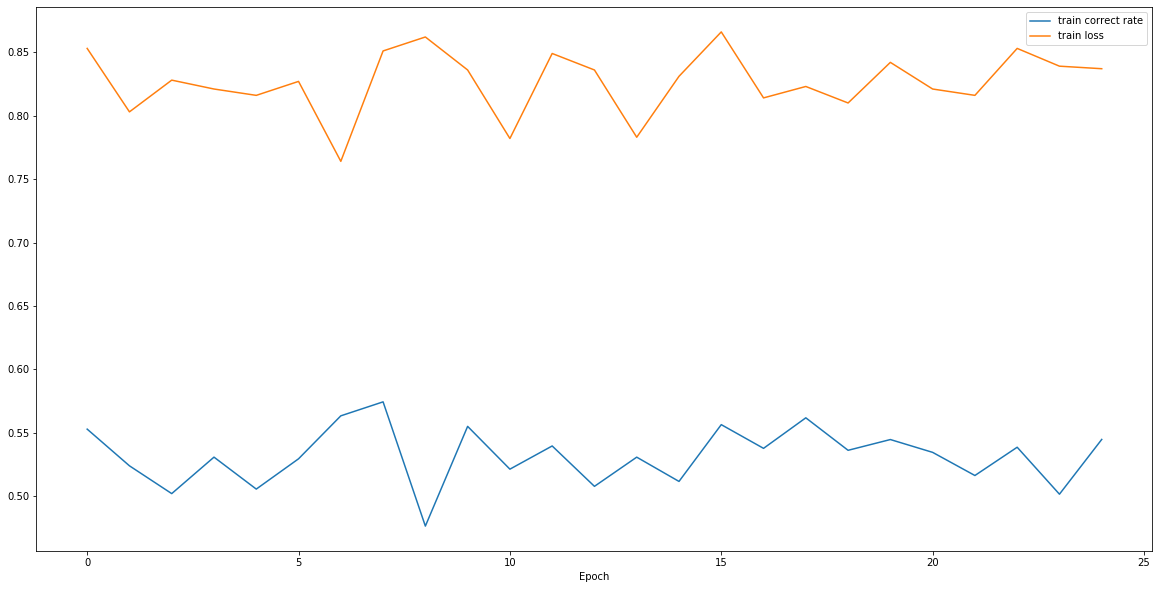

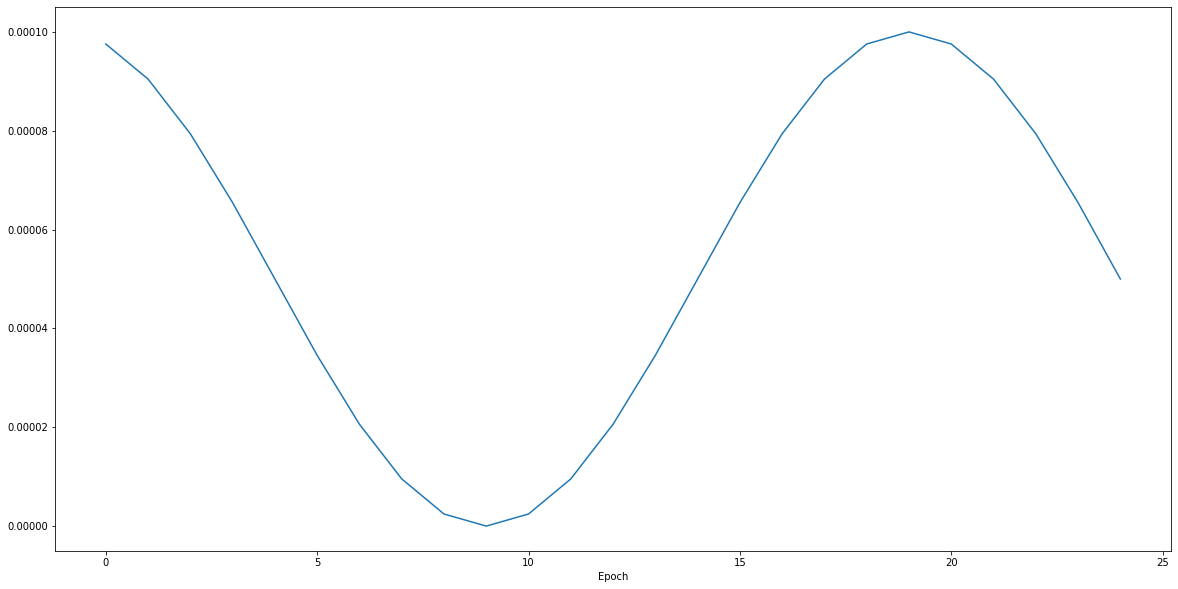

In [24]:
plot_train_info()
plot_lerning_rate()

### Test DenseNet

In [25]:
model_PATH = f"{gd_root}/models/{PATH_Dense}"
test_densenet_net = DenseNet121()
test_densenet_net.to(device)
if device == 'cuda':
    test_densenet_net = torch.nn.DataParallel(test_densenet_net)
    cudnn.benchmark = True
test_densenet_net.load_state_dict(torch.load(model_PATH))

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

<All keys matched successfully>

In [26]:
testing(test_densenet_net)

Progress:  99% |####################### | Elapsed Time: 0:00:08 ETA:   0:00:00 


Accuracy of the network on the 10000 test images: 92.36%


In [27]:
test_for_each(test_densenet_net)

Progress:  99% |####################### | Elapsed Time: 0:00:08 ETA:   0:00:00 


Accuracy of airplane : 94.69%
Accuracy of automobile : 98.26%
Accuracy of bird : 86.18%
Accuracy of cat : 85.27%
Accuracy of deer : 93.18%
Accuracy of dog : 89.38%
Accuracy of frog : 91.74%
Accuracy of horse : 93.75%
Accuracy of ship : 96.46%
Accuracy of truck : 97.79%


---
---
## Run the model in project test data 

### Load test data

In [29]:
project_testset = np.load(f"{gd_root}/data/test_data/y_test.npy").astype(np.uint8)
project_testset = np.moveaxis(project_testset, -1, 2)
project_testset = np.moveaxis(project_testset, 2, 1)
project_testset.shape
type(project_testset)

(12000, 3, 32, 32)

numpy.ndarray

### Convert to DataLoader ([Convertion Reference](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader))

In [30]:
from torch.utils import data
tensor_testset = torch.Tensor(project_testset)
the_dataset = data.TensorDataset(tensor_testset)
project_test_loader = data.DataLoader(the_dataset, 
                                      batch_size=32,
                                      num_workers=8,
                                      pin_memory=True
                                     )
test_batch_len = len(project_test_loader)

### Run the test

In [31]:
predict_result = []

In [32]:
def run_project_test(net, model_path):
    net.load_state_dict(torch.load(model_path))
    
    test_pbar = progress_bar(test_batch_len)
    
    with torch.no_grad():
        for index, imgs in enumerate(project_test_loader):
            
            imgs = torch.stack([torch.Tensor(i) for i in imgs]).squeeze()
            
            if device == 'cuda':
                imgs.cuda()
                
            outputs = net(imgs)
            _, predicted = torch.max(outputs.data, 1)
            
            for p in predicted:
                predict_result.append(p.item())
            
            test_pbar.update(index)
      
    print_time_and_msg(f"Testd {len(predict_result)} images")

In [33]:
model_PATH = f"{gd_root}/models/{PATH_Dense}"  # PATH_DPN
# p_test_net = DPN92()
p_test_net = DenseNet121()
if device == 'cuda':
    p_test_net.to(device)
    p_test_net = torch.nn.DataParallel(p_test_net)
    cudnn.benchmark = True
run_project_test(p_test_net, model_PATH)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Progress:  98% |####################### | Elapsed Time: 0:00:09 ETA:   0:00:00 

[23:51:56] - Testd 12000 images


### Save to csv file

In [34]:
def save_to_csv(result: list):
    result_df = pd.DataFrame(
        list(predict_result),
        columns=["Category"]
    )
    result_df.index.name = "Index"
    print(result_df.shape)
    result_df.to_csv(f"{gd_root}/predicted-result.csv")

In [35]:
save_to_csv(predict_result)

(12000, 1)
